<a href="https://colab.research.google.com/github/julialromero/Collaborative-Problem-Solving/blob/main/learning_pipeline_binary_classification_60s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [23]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import os
from skimage import io
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras import layers, Input, Model, optimizers
from keras.applications.inception_v3 import InceptionV3
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix



gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

PROJECT_DIR = "drive/MyDrive/CSCI 5922 - Final Project/"  #<--- Make a shortcut for the "CSCI 5922 - Final Project" shared folder on your Google Drive

Wed Jun  1 17:56:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                  N/A |
| N/A   37C    P0    34W / 250W |    389MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Get User Input

In [92]:
# Choose what size images to use
PROJECT_DIR = "drive/MyDrive/CSCI 5922 - Final Project/"  #<--- Make a shortcut for the "CSCI 5922 - Final Project" shared folder on your Google Drive
## "small" = 98x98, "med" = 266x266, "large" = 332x332
image_size = "small"
shuffled = False
chance = False
normalize = False
scaled = False
num_iters = 1
num_folds = 10
threshold = 0.5
num_epochs = 50

if image_size == "large":
  imgsize = (332, 332)
  if shuffled:
    IMG_DIR = "332x332 - Levels Recurrence Matrices/RAW_SHUFFLED/"
  else:
    IMG_DIR = "332x332 - Levels Recurrence Matrices/RAW/"

elif image_size == "med":
  imgsize = (266, 266)
  if shuffled:
    IMG_DIR = "332x332 - Levels Recurrence Matrices/RAW_SHUFFLED/"
  else:
    IMG_DIR = "332x332 - Levels Recurrence Matrices/RAW/"

elif image_size == "small":
  imgsize = (98, 98)
  if shuffled:
    IMG_DIR = "98x98 - Levels Recurrence Matrices/RAW_SHUFFLED/"
  else:
    IMG_DIR = "98x98 - Levels Recurrence Matrices/RAW/"

print("Processing images from: ", IMG_DIR)

Processing images from:  98x98 - Levels Recurrence Matrices/RAW/


# Helper Functions

In [57]:
'''
    read, preprocess, and scale images to uniform dimension
'''
def extract_image(image_path):
    imag = io.imread(image_path, as_gray=True)
    x = image.img_to_array(imag)

    x = tf.image.resize(x, imgsize) 

    return x

'''
    Converts grayscale image to 3 channels in order to fit Inception v3 model
'''
def extract_image_inceptionv3(image_path):
    imag = io.imread(image_path, as_gray=True)
    x = image.img_to_array(imag)

    x = tf.image.resize(x, imgsize) 
    x = np.squeeze(np.stack((x,)*3))
    x = x.swapaxes(0,1)
    x = x.swapaxes(1,2)

    return x

def extract_level_score(filename, outcome_df, score_col="won", shuffled=False):
    #  match this file's id/block with task score and return
    if shuffled:
      GROUPID, UniqueID, NA = filename.split("_")
    else:
      s, NA = filename.split(".png")
      GROUPID, UniqueID = s.split("_")

    row = outcome_df.loc[(outcome_df.UniqueID == UniqueID)]

    if(row.shape[0] != 1):
        print(f"Error -- Number of level scores recorded is not 1 for {UniqueID}")
        return np.nan
    score = row[score_col].values[0]
    return score


def get_levels_fold_data(GROUPID_list, outcome_df, score_col, incv3=False, verbose=False):
  # read data to np arrays
  if incv3:
    recurrence_plot_list_incv3 = []
  else:
    recurrence_plot_list = []
  
  levels_labels = []

  for filename in os.listdir(PROJECT_DIR + IMG_DIR):
      # print("filename: ", filename)

      # Check if file belongs to one of the teams in the desired group
      for GROUPID in GROUPID_list:
        if str(GROUPID) == filename.split("_")[0]:
          # preprocess image
          if incv3:
            t_incv3 = extract_image_inceptionv3(PROJECT_DIR + IMG_DIR + filename)
          else:
            t = extract_image(PROJECT_DIR + IMG_DIR + filename)

          # get level score
          lab = extract_level_score(filename, outcome_df=outcome_df, score_col=score_col, shuffled=shuffled)

          # append data 
          if incv3:
            recurrence_plot_list_incv3.append(t_incv3)
          else:
            recurrence_plot_list.append(t)
          
          levels_labels.append(lab)

  # convert to arrays 
  if incv3:
    recurrence_plot_list_incv3 = np.array(recurrence_plot_list_incv3)
    plot_list = recurrence_plot_list_incv3
  else:
    recurrence_plot_list = np.array(recurrence_plot_list)
    plot_list = recurrence_plot_list
  
  labels = np.array(levels_labels)

  if verbose:
    print("\nFOLD DATA INFO: ")
    if incv3:
      print(f"\trecurrence_plot_list_incv3: {recurrence_plot_list_incv3.shape}")
    else:
      print(f"\trecurrence_plot_list: {recurrence_plot_list.shape}")
    
    binary_counts = dict(Counter(labels))
    print("\tBinary label counts: ", binary_counts)

  return [plot_list, labels]


def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None,
                          save_fn=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

    if save_fn:
      plt.savefig(save_fn + ".svg", dpi=300, format="svg")
      plt.savefig(save_fn + ".png", dpi=300, format="png")

# Load Outcomes

In [58]:
outcome_df = pd.read_csv(PROJECT_DIR + "Level_Attempts_60s.csv")

outcome_df

,UniqueID,school,team,block,level,relative_start_time,relative_end_time,60_sec_start_time,60_sec_end_time,level_duration,gold_trophy,silver_trophy,won,GROUPID
0,CPS2-ASU-T100-ExpBlock1-49.9049,ASU,CPS2-ASU-T100,ExpBlock1,Top spin,49.9049,899.9790,840,899,850.0741,0,0,0,10100
1,CPS2-ASU-T100-ExpBlock2-155.1167,ASU,CPS2-ASU-T100,ExpBlock2,Timing is Everything,155.1167,413.1691,344,403,258.0524,0,1,1,10100
2,CPS2-ASU-T100-ExpBlock2-19.7534,ASU,CPS2-ASU-T100,ExpBlock2,Scale,19.7534,144.8036,75,134,125.0502,0,1,1,10100
3,CPS2-ASU-T100-ExpBlock2-419.7154,ASU,CPS2-ASU-T100,ExpBlock2,Green Apple,419.7154,496.1897,427,486,76.4743,0,1,1,10100
4,CPS2-ASU-T100-ExpBlock2-506.7689,ASU,CPS2-ASU-T100,ExpBlock2,Fe2,506.7689,900.0460,840,899,393.2771,0,0,0,10100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760,CPS2-CU-T71-ExpBlock2-768.7043,CU,CPS2-CU-T71,ExpBlock2,Timing is Everything,768.7043,900.0360,840,899,131.3317,0,0,0,2071
761,CPS2-CU-T71-Warmup-324.6296,CU,CPS2-CU-T71,Warmup,Yippie!,324.6296,447.6709,378,437,123.0413,0,1,1,2071
762,CPS2-CU-T71-Warmup-454.0428,CU,CPS2-CU-T71,Warmup,Spider Web,454.0428,618.0744,549,608,164.0316,0,1,1,2071
763,CPS2-CU-T71-Warmup-627.1388,CU,CPS2-CU-T71,Warmup,Annoying Lever,627.1388,900.0090,840,899,272.8702,0,0,0,2071


# Binary Classification w/ Team-level Cross Validation

## Prep folds for team-level cross validation

In [65]:
# Define fold names
train_folds = []
test_folds = []
set_type = "test"
for j in range(1,num_folds+1): 
    col_name = "Fold" + str(j) + "_" + set_type
    test_folds.append(col_name)
    set_type = "train"  
    col_name = "Fold" + str(j) + "_" + set_type
    train_folds.append(col_name)
    set_type = "test"

folds_dict_list = []

teams = pd.unique(outcome_df.GROUPID)

# For every iteration
for i in range(1,num_iters+1):
    print("Iteration: ", i)
    teams = shuffle(teams, random_state=i)
    groups = np.array_split(teams, num_folds)
    
    # Define groups for each fold
    fold_groups = {}
    for j, (train_fold, test_fold) in enumerate(zip(train_folds, test_folds)):
        # make the current group the test group
        fold_groups[test_fold] = groups[j]
        # make all other groups the train group
        train_group = groups[:j] + groups[j+1:]
        train_group = [team for group in train_group for team in group]
        fold_groups[train_fold] = train_group
        
    ## Confirm that for each fold, there is no team overlap bewteen train and test set
    for j in range(1,num_folds+1):
        assert set(fold_groups['Fold'+str(j)+'_test']).isdisjoint(set(fold_groups['Fold'+str(j)+'_train'])), "There is overlap in train and test set " + str(j)
    
    print("* No team overlap *")

      
    # Add fold groups to dictionary
    folds_dict_list.append(fold_groups)
    

# Informational
print("\nNumber of iterations: ", len(folds_dict_list))

print("\nIterating through folds_dict_list to check for overlap...")
for i,dicti in enumerate(folds_dict_list):
    for j in range(1,num_folds+1):
        assert set(dicti['Fold'+str(j)+'_test']).isdisjoint(set(dicti['Fold'+str(j)+'_train'])), "There is overlap in train and test set " + str(j)
    
print("* No team overlap *")  



Iteration:  1
* No team overlap *

Number of iterations:  1

Iterating through folds_dict_list to check for overlap...
* No team overlap *


## Prepare Garcia Model

In [93]:
def get_binary_garcia_model():
  # Garcia-Ceja paper feeds CNN images with dims 100 x 100 x 4 (width x height x channels)
  # Labels are one hot encoded
  inputs = Input(shape=(imgsize[0], imgsize[1], 1))
  x = layers.Conv2D(filters=16, kernel_size=3, strides=(1, 1), activation="relu")(inputs)
  x = layers.Conv2D(filters=16, kernel_size=3, strides=(1, 1), activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Dropout(0.25)(x)

  x = layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation="relu")(x)
  x = layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation="relu")(x)
  x = layers.MaxPooling2D(pool_size=(2, 2))(x)
  x = layers.Dropout(0.25)(x)

  x = layers.Dense(512, activation="relu")(x) 
  x = layers.Dropout(0.50)(x)

  x = layers.Flatten()(x)
  out = layers.Dense(1, activation="sigmoid")(x)   # changed output layer to 1 and activation to sigmoid
    

  bc = tf.keras.losses.BinaryCrossentropy()        # changed loss to binary
  lr = 0.00001 # paper used 0.001, our regression used 0.0001
  eps = 1e-08  # paper used 1e-08, but keras default is 1e-07
  adam = keras.optimizers.Adam(learning_rate=lr, epsilon=eps)
  auc = tf.keras.metrics.AUC(
        num_thresholds=200,
        curve="ROC",
        from_logits=False
  )
  prec = tf.keras.metrics.Precision()
  rec = tf.keras.metrics.Recall()


  model_garcia = Model(inputs=inputs, outputs=out)
  model_garcia.compile(
    optimizer=adam,
    loss=bc, 
    metrics=['accuracy', auc, prec, rec]
  )

  return model_garcia

model_garcia = get_binary_garcia_model()
model_garcia.summary()


Model: "model_150"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_151 (InputLayer)      [(None, 98, 98, 1)]       0         
                                                                 
 conv2d_600 (Conv2D)         (None, 96, 96, 16)        160       
                                                                 
 conv2d_601 (Conv2D)         (None, 94, 94, 16)        2320      
                                                                 
 max_pooling2d_300 (MaxPooli  (None, 47, 47, 16)       0         
 ng2D)                                                           
                                                                 
 dropout_450 (Dropout)       (None, 47, 47, 16)        0         
                                                                 
 conv2d_602 (Conv2D)         (None, 45, 45, 32)        4640      
                                                         

## Garcia - Run team-level cross validation

Iteration:  1
	Fold:  1
Epoch 1/50
22/22 [==============================] - 1s 13ms/step - loss: 0.6944 - accuracy: 0.4837 - auc_151: 0.4631 - precision_151: 0.5017 - recall_151: 0.8575
Epoch 2/50
22/22 [==============================] - 0s 13ms/step - loss: 0.6920 - accuracy: 0.5148 - auc_151: 0.5184 - precision_151: 0.5171 - recall_151: 0.9886
Epoch 3/50
22/22 [==============================] - 0s 12ms/step - loss: 0.6933 - accuracy: 0.5104 - auc_151: 0.4864 - precision_151: 0.5155 - recall_151: 0.9459
Epoch 4/50
22/22 [==============================] - 0s 12ms/step - loss: 0.6926 - accuracy: 0.5207 - auc_151: 0.4888 - precision_151: 0.5209 - recall_151: 0.9601
Epoch 5/50
22/22 [==============================] - 0s 12ms/step - loss: 0.6921 - accuracy: 0.5178 - auc_151: 0.5152 - precision_151: 0.5185 - recall_151: 0.9972
Epoch 6/50
22/22 [==============================] - 0s 12ms/step - loss: 0.6928 - accuracy: 0.5178 - auc_151: 0.4987 - precision_151: 0.5185 - recall_151: 0.9972
Epoc

,iteration,accuracy,auroc,precision,recall
0,1,0.529412,0.52778,0.541818,0.73399


Averages over all iterations: 
      AUROC: 0.53
  Precision: 0.54
     Recall: 0.73
   Accuracy: 0.53

Median iteration number:  1

Median AUROC: 0.53


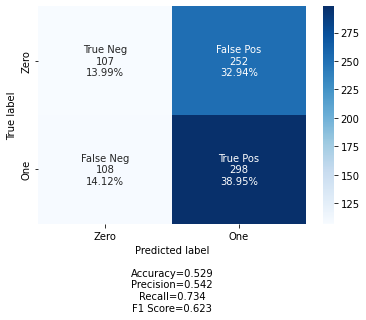

In [94]:
# Store metrics for all iterations
aurocs = []
precision = []
recall = []
accuracy = []

all_y_test_task_score = [[] for i in range(num_iters)]
predictions_task_score = [[] for i in range(num_iters)]
predict_proba_task_score = [[] for i in range(num_iters)]


# For each iteration 
for i in range(num_iters):
    print("Iteration: ", i+1)
    
    # Lists for cumulative predictions for iteration
    all_y_test = []
    predictions = []
    predict_proba = []
    
    # Get fold groups
    fold_groups = folds_dict_list[i]

    # For each fold
    for j, (test_fold, train_fold) in enumerate(zip(test_folds, train_folds)):
        print("\tFold: ", j+1)

        # Get data for teams in test set
        [plot_list, labels] = get_levels_fold_data(fold_groups[test_fold], outcome_df=outcome_df, score_col="won", incv3=False)
        X_test = plot_list
        y_test = labels
        all_y_test.extend(y_test.tolist())

        # Get data for teams in train set
        [plot_list, labels] = get_levels_fold_data(fold_groups[train_fold], outcome_df=outcome_df, score_col="won", incv3=False)
        X_train = plot_list
        y_train = labels

        # Train model
        model_garcia = get_binary_garcia_model()
        info_garcia_cv = model_garcia.fit(x=X_train, y=y_train, epochs=num_epochs, verbose=True)

        # Test model: https://androidkt.com/get-class-labels-from-predict-method-in-keras/
        y_pp = model_garcia.predict(X_test)
        y_pred = np.where(y_pp > threshold, 1, 0)

        predict_proba.extend(y_pp.tolist())
        predictions.extend(y_pred.tolist())

    # ----- END OF FOLDS

    all_y_test = np.array(all_y_test)
    all_y_test_task_score[i] = all_y_test

    predictions = np.squeeze(np.array(predictions))
    predict_proba = np.squeeze(np.array(predict_proba))
    
    predictions_task_score[i] = predictions
    predict_proba_task_score[i] = predict_proba

    # Get metrics of iteration
    auroc = roc_auc_score(all_y_test, predict_proba)
    prec = precision_score(all_y_test, predictions)
    rec = recall_score(all_y_test, predictions)
    acc = accuracy_score(all_y_test, predictions)
    
    aurocs.append(auroc)
    precision.append(prec)
    recall.append(rec)
    accuracy.append(acc)

    # Save actual labels and predictions for iteration
    dfTruevPred = pd.DataFrame({'actual': all_y_test, 'predict_proba': predict_proba, 'prediction': predictions})
    if shuffled:
      ACTvPRED_SAVE_DIR = PROJECT_DIR + "level_attempt_results/Garcia_model/shuffled/" + image_size + "/" + image_size + "_TaskScore_True_vs_Pred_SHUFF_" + str(i+1) + ".csv"
    else:
      ACTvPRED_SAVE_DIR = PROJECT_DIR + "level_attempt_results/Garcia_model/non-shuffled/" + image_size + "/" + image_size + "_TaskScore_True_vs_Pred_" + str(i+1) + ".csv"
    dfTruevPred.to_csv(ACTvPRED_SAVE_DIR, index=False) 

# ----- END OF ITERATIONS

print("\n =========== ALL ITERATIONS RESULTS SUMMARY ===========")
dfMetrics = pd.DataFrame({'iteration': [i for i in range(1,num_iters+1)], 'accuracy': accuracy, \
                          'auroc': aurocs, 'precision': precision, 'recall': recall})

display(dfMetrics)

if shuffled:
  METRICS_SAVE_DIR = PROJECT_DIR + "level_attempt_results/Garcia_model/shuffled/" + image_size + "/" + image_size + "_TaskScore_Metrics_SHUFF.csv"
else:
  METRICS_SAVE_DIR = PROJECT_DIR + "level_attempt_results/Garcia_model/non-shuffled/" + image_size + "/" + image_size + "_TaskScore_Metrics.csv"
dfMetrics.to_csv(METRICS_SAVE_DIR, index=False) 

print("Averages over all iterations: ")
print("%12s %.2f" % ("AUROC:", np.mean(dfMetrics['auroc'])))
print("%12s %.2f" % ("Precision:", np.mean(dfMetrics['precision'])))
print("%12s %.2f" % ("Recall:", np.mean(dfMetrics['recall'])))
print("%12s %.2f" % ("Accuracy:", np.mean(dfMetrics['accuracy'])))

# Get median iterations
med_auroc = np.median(aurocs)
med_auroc_idx = np.argsort(aurocs)[len(aurocs)//2]
med_iter_num = med_auroc_idx+1
med_data = data = [[med_iter_num, med_auroc]]
dfMedian = pd.DataFrame(med_data, columns=['med_iter_num', 'med_auroc'])

if shuffled:
  MEDIAN_SAVE_DIR = PROJECT_DIR + "level_attempt_results/Garcia_model/shuffled/" + image_size + "/" + image_size + "_Median_SHUFF.csv"
else:
  MEDIAN_SAVE_DIR = PROJECT_DIR + "level_attempt_results/Garcia_model/non-shuffled/" + image_size + "/" + image_size + "_Median.csv"
dfMedian.to_csv(MEDIAN_SAVE_DIR, index=False) 

print("\nMedian iteration number: ", med_iter_num)
print("\n%6s %.2f" % ("Median AUROC:", np.median(dfMetrics['auroc'])))

# Plot confusion matrix of median iteration
if shuffled:
  CM_SAVE_DIR = PROJECT_DIR + "level_attempt_results/Garcia_model/shuffled/" + image_size + "/" + image_size + "_CM_SHUFF"
else:
  CM_SAVE_DIR = PROJECT_DIR + "level_attempt_results/Garcia_model/non-shuffled/" + image_size + "/" + image_size + "_CM"

cf_matrix = confusion_matrix(all_y_test_task_score[med_auroc_idx], predictions_task_score[med_auroc_idx])
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',
                      save_fn = CM_SAVE_DIR)



# Troubleshoot

In [ ]:
plot_list.shape


(0,)